In [3]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import Dataset as HFDataset
from PIL import Image
import json
import os
from tqdm import tqdm
import torch
import os

# Set CUDA environment variable to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

class ChartDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, processor):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.processor = processor
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return min(1000,len(self.image_files))

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        annotation_file = image_file.replace('.jpg', '.json')

        # Load image
        image_path = os.path.join(self.images_dir, image_file)
        image = Image.open(image_path).convert("RGB")

        # Load annotation
        annotation_path = os.path.join(self.annotations_dir, annotation_file)
        with open(annotation_path, 'r') as f:
            annotation = json.load(f)

        # Extract data-series from annotation
        data_series = annotation.get("data-series", [])
        for entry in data_series:
            entry["y"] = round(float(entry["y"]), 8)  # Ensure y has 8 decimal places

            
        # Preprocess the image with the text "Generate data series"
        inputs = self.processor(images=image, text="Generate data series:", return_tensors="pt")

        return {
            "flattened_patches": inputs["flattened_patches"].squeeze(),
            "labels": torch.tensor(self.processor.tokenizer(json.dumps(data_series), padding="max_length", max_length=512, truncation=True).input_ids)  # Reduced max_length
        }

# Custom data collator
def custom_data_collator(features):
    flattened_patches = torch.stack([feature["flattened_patches"] for feature in features])
    labels = torch.nn.utils.rnn.pad_sequence([feature["labels"] for feature in features], batch_first=True, padding_value=-100)
    return {"flattened_patches": flattened_patches, "labels": labels}

# Paths to your data directories
images_dir = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/line/images"
annotations_dir = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/line/annotations"

# Load processor and model
model = Pix2StructForConditionalGeneration.from_pretrained("google/deplot")
processor = AutoProcessor.from_pretrained("google/deplot")

# Prepare dataset
dataset = ChartDataset(images_dir, annotations_dir, processor)

# Split dataset into training and evaluation
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Use DataLoader for lazy loading and batching
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)




In [4]:
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/deplot_finetuned",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,  # Further reduced batch size
    per_device_eval_batch_size=1,  # Further reduced batch size
    num_train_epochs=5,
    save_strategy="epoch",
    save_total_limit=2,
    predict_with_generate=True,
    fp16=True,
    logging_dir="/kaggle/working/logs",
    logging_steps=200,
    push_to_hub=False,
    dataloader_num_workers=2,  # Reduced workers
    ddp_find_unused_parameters=False,
    report_to=["none"],
    gradient_accumulation_steps=2,  # Reduced gradient accumulation
    no_cuda=False,
    load_best_model_at_end=True
)



In [5]:
# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=eval_dataset,    # Evaluation dataset
    tokenizer=processor.tokenizer,
    data_collator=custom_data_collator
)

# Train model
trainer.train()

# Save the model
model.save_pretrained("/kaggle/working/deplot_finetuned")
processor.save_pretrained("/kaggle/working/deplot_finetuned")

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,3.029800,2.224351
2,1.853300,1.555955
3,1.308300,1.104950
4,0.975900,0.872039
5,0.830000,0.810469


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0

[]

In [ ]:
print("model saved")

In [6]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration
from PIL import Image

# Load the fine-tuned model and processor
#model = Pix2StructForConditionalGeneration.from_pretrained("/kaggle/input/deplot-finetuned-line-version-2")
#processor = AutoProcessor.from_pretrained("/kaggle/input/deplot-finetuned-line-version-2")


In [8]:
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import json
import os
import torch
from transformers import AutoProcessor, Pix2StructForConditionalGeneration
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and processor
model = Pix2StructForConditionalGeneration.from_pretrained("/kaggle/working/deplot_finetuned").to(device)
processor = AutoProcessor.from_pretrained("/kaggle/working/deplot_finetuned")

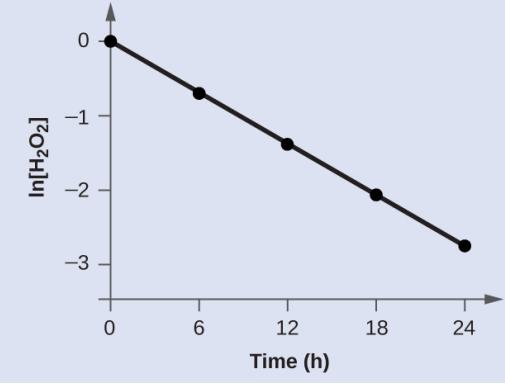

[{"x": "0", "y": 0.01949999}, {"x": "6", "y": -1.29499999}, {"x": "12", "y": -1.39999999}, {"x": "18", "y": -1.95999999}, {"x": "24", "y": -3.21011111}]


In [9]:
# Load an example image for prediction
image_path = "/kaggle/input/benetech-making-graphs-accessible/test/images/000b92c3b098.jpg"
image = Image.open(image_path)
display(image)

inputs = processor(images=image, text="Generate data series:", return_tensors="pt")

# Move inputs to GPU
inputs = {key: value.to(device) for key, value in inputs.items()}

predictions = model.generate(**inputs, max_new_tokens=2048)
print(processor.decode(predictions[0], skip_special_tokens=True))

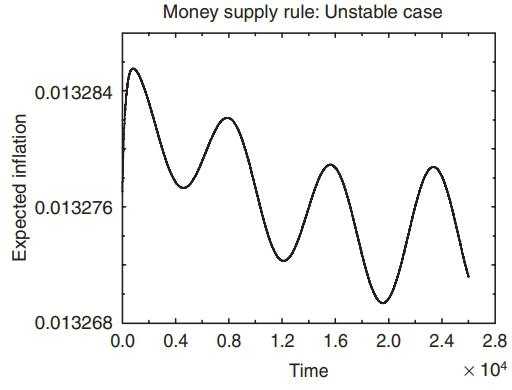

[{"x": "0.0", "y": 0.01328411}, {"x": "0.4", "y": 0.01327648}, {"x": "0.8", "y": 0.01335158}, {"x": "1.2", "y": 0.01327515}, {"x": "1.6", "y": 0.01327658}, {"x": "2.0", "y": 0.01326856}, {"x": "2.4", "y": 0.01327658}, {"x": "2.8", "y": 0.01328054}]


In [10]:
# Load an example image for prediction
image_path = "/kaggle/input/benetech-making-graphs-accessible/test/images/007a18eb4e09.jpg"
image = Image.open(image_path)
display(image)

inputs = processor(images=image, text="Generate data series:", return_tensors="pt")

# Move inputs to GPU
inputs = {key: value.to(device) for key, value in inputs.items()}

predictions = model.generate(**inputs, max_new_tokens=2048)
print(processor.decode(predictions[0], skip_special_tokens=True))

In [ ]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import pandas as pd
import json
import os
import torch

# Set CUDA environment variable to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

class CSVChartDataset(Dataset):
    def __init__(self, images_dir, annotations_csv, processor):
        self.images_dir = images_dir
        self.annotations = pd.read_csv(annotations_csv)
        self.processor = processor

    def __len__(self):
        return min(1000, len(self.annotations))  # Use only 1000 images for fine-tuning

    def __getitem__(self, idx):
        idx = idx + 210000
        row = self.annotations.iloc[idx]
        image_path = os.path.join(self.images_dir, os.path.basename(row["file_name"]))
        data_series = row["text"]

        # Convert the data-series to JSON-like format
        data_series_json = []
        for pair in data_series.split("<0x0A>"):
            if "|" in pair:
                x, y = pair.split("|")
                data_series_json.append({"x": x.strip(), "y": round(float(y.strip()), 4)})

        # Load image
        image = Image.open(image_path).convert("RGB")

        # Preprocess the image and data series
        inputs = self.processor(images=image, text="Generate data series:", return_tensors="pt")

        return {
            "flattened_patches": inputs["flattened_patches"].squeeze(),
            "labels": torch.tensor(
                self.processor.tokenizer(
                    json.dumps(data_series_json, ensure_ascii=False),
                    padding="max_length",
                    max_length=512,
                    truncation=True
                ).input_ids
            )
        }

# Custom data collator
def custom_data_collator(features):
    flattened_patches = torch.stack([feature["flattened_patches"] for feature in features])
    labels = torch.nn.utils.rnn.pad_sequence([feature["labels"] for feature in features], batch_first=True, padding_value=-100)
    return {"flattened_patches": flattened_patches, "labels": labels}

# Paths to your data directories
images_dir = "/kaggle/input/benetech-extra-generated-data/graphs_l"
annotations_csv = "/kaggle/input/benetech-extra-generated-data/metadata.csv"

# Load processor and model
#model = Pix2StructForConditionalGeneration.from_pretrained("/kaggle/input/deplot-finetuned-dot/deplot_finetuned")  # Load previously fine-tuned model
#processor = AutoProcessor.from_pretrained("/kaggle/input/deplot-finetuned-dot/deplot_finetuned")

# Prepare dataset
dataset = CSVChartDataset(images_dir, annotations_csv, processor)

# Split dataset into training and evaluation
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/deplot_finetuned_v2",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    save_strategy="epoch",
    save_total_limit=2,
    predict_with_generate=True,
    fp16=True,
    logging_dir="/kaggle/working/logs_v2",
    logging_steps=100,
    push_to_hub=False,
    dataloader_num_workers=2,
    ddp_find_unused_parameters=False,
    report_to=["none"],
    gradient_accumulation_steps=2,
    no_cuda=False,
    load_best_model_at_end=True
)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.tokenizer,
    data_collator=custom_data_collator
)

# Train model
trainer.train()

# Save the model
model.save_pretrained("/kaggle/working/deplot_finetuned_v2")
processor.save_pretrained("/kaggle/working/deplot_finetuned_v2")


In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import json
import os
import torch
from transformers import AutoProcessor, Pix2StructForConditionalGeneration
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and processor
model = Pix2StructForConditionalGeneration.from_pretrained("/kaggle/input/deplot-finetuned-line-version-2").to(device)
processor = AutoProcessor.from_pretrained("/kaggle/input/deplot-finetuned-line-version-2")

In [ ]:
# Load an example image for prediction
image_path = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/line/images/0003a50817cf.jpg"
image = Image.open(image_path)
display(image)

inputs = processor(images=image, text="Generate data series:", return_tensors="pt")

# Move inputs to GPU
inputs = {key: value.to(device) for key, value in inputs.items()}

predictions = model.generate(**inputs, max_new_tokens=2048)
print(processor.decode(predictions[0], skip_special_tokens=True))

In [ ]:
print("\n\n\nstart loop:")
for i in range(84360, 84401):
    image_path = f"/kaggle/input/benetech-extra-generated-data/graphs_l/{i}.jpg"
    try:
        image = Image.open(image_path)
        display(image)
        inputs = processor(images=image, text="Generate data series:", return_tensors="pt")
        
        # Move inputs to GPU
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        predictions = model.generate(**inputs, max_new_tokens=2048)
        print(processor.decode(predictions[0], skip_special_tokens=True))
    except FileNotFoundError:
        print(f"Image not found: {image_path}")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

In [ ]:
import os
from PIL import Image
import torch

# Folder path
folder_path = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/vertical_bar/images"
cnt = 0

# Iterate over the images
for image_file in os.listdir(folder_path):
    # Stop after processing 40 images
    if cnt >= 40:
        break
    
    image_path = os.path.join(folder_path, image_file)
    
    # Ensure the file is an image
    if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    
    cnt += 1
    image = Image.open(image_path)
    display(image)

    # Prepare inputs
    inputs = processor(images=image, text="Generate data series:", return_tensors="pt")

    # Move inputs to GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate predictions
    predictions = model.generate(**inputs, max_new_tokens=2048)

    # Decode and print predictions
    print(f"Predictions for {image_file}:")
    print(processor.decode(predictions[0], skip_special_tokens=True))
